In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%cd /content/drive/MyDrive/GRM_proj/

Mounted at /content/drive
/content/drive/MyDrive/GRM_proj


In [2]:
!pip install PyMaxFlow

Image shape :  (128, 128, 3)


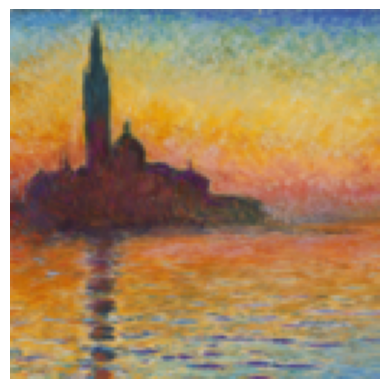

In [2]:
from PIL import Image
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image =  loader(image).unsqueeze(0).to(device, torch.float)[:, :3][0]
    image = image.cpu().numpy().transpose(1,2,0)
    return image

content_img = image_loader("data/images/dance2.png")
style_img = image_loader("data/images/monnet.png")


print("Image shape : ",content_img.shape)

plt.imshow(content_img)
plt.axis('off');
plt.imshow(style_img)
plt.axis('off');

In [3]:
from src.energy import style_transfer

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


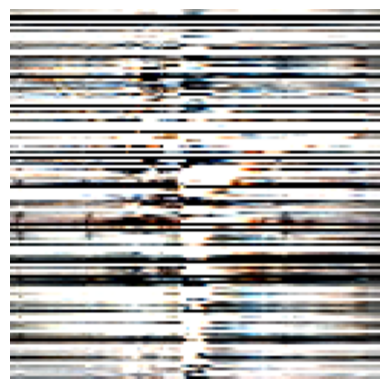

In [4]:
transfered_features = style_transfer(content_img, style_img)

plt.imshow(transfered_features)
plt.axis('off');

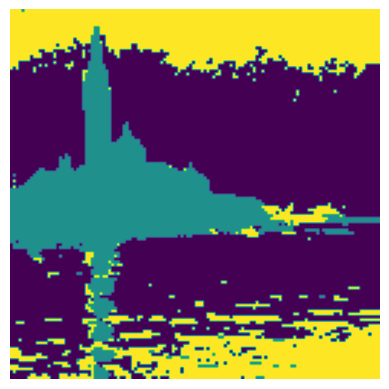

In [5]:
from src.energy import cluster_style

from sklearn.cluster import KMeans

style_img_flat = style_img.reshape((-1,3))
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(style_img_flat)
cluster_labels = kmeans.labels_.reshape(content_img.shape[:2])

plt.imshow(cluster_labels)
plt.axis('off');

Distance array shape :  (3, 128, 128)
Distance image shape :  (128, 128)


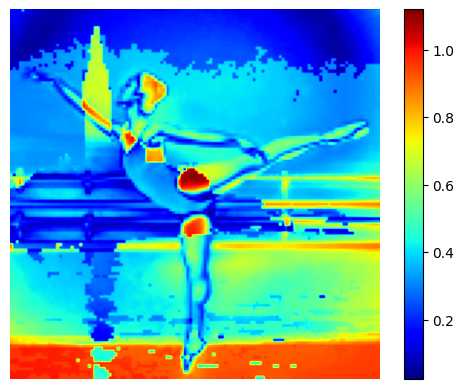

In [6]:
from src.energy import data_energy

cluster_centers = kmeans.cluster_centers_
n_clusters=3

# distance to cluster centers
distance_array = np.zeros((n_clusters,imsize,imsize), dtype=np.float32)
distance_img = np.zeros_like(cluster_labels,dtype=np.float32)
print("Distance array shape : ",distance_array.shape)
print("Distance image shape : ",distance_img.shape)

for i, cluster_center in enumerate(cluster_centers):
    distances = np.linalg.norm(content_img - cluster_center, axis=2)
    distance_array[i] = distances
    mask = (cluster_labels == i)
    distance_img[mask] = np.linalg.norm(content_img[mask] - cluster_center, axis=1)

plt.imshow(distance_img.reshape((imsize,imsize)), cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

In [7]:
distances = distance_array.transpose(1,2,0)
greedy_assignments = np.argmin(distances,axis=2)


In [9]:
!pip install igraph

In [8]:
import graph_cut as gc
from maxflow.fastmin import aexpansion_grid

beta=1e-3

smooth_term = beta * (1 - np.eye(n_clusters))
data_term = distances.copy().astype(np.double)

labels = aexpansion_grid(data_term, smooth_term, max_cycles=None)

#gc.plot_images(content_img, style_img, labels)

In [9]:
cluster_list = [style_img[cluster_labels == i] for i in range(3)]
cluster_list[0].shape

(9329, 3)

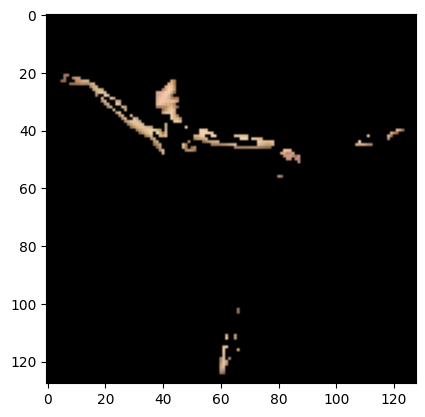

In [10]:
plt.imshow((content_img.transpose(2,0,1)* (labels == 0).astype(int)).transpose(1,2,0))

In [ ]:
from src.energy import feature_WCT
from tqdm.notebook import tqdm

transfered_features = np.zeros(content_img.shape)
for i in tqdm(range(3)):
    label = (labels == i).astype(int) # (height, width)
    print(label.shape)
    print(cluster_list[i].shape)
    transfered_features += feature_WCT(content_img.transpose(2,0,1), cluster_list[i].transpose(1,0), label, 0.6)

  0%|          | 0/3 [00:00<?, ?it/s]

(128, 128)
(9329, 3)


In [19]:
style_features_view = style_img.reshape(style_img.shape[0], -1).T  # (height * width, channel)
kmeans = KMeans(n_clusters=3).fit(style_features_view)

cluster_centers = kmeans.cluster_centers_
cluster_list = [style_features_view[kmeans.labels_ == i] for i in range(3)]

distance_array = np.zeros((n_clusters,imsize,imsize), dtype=np.float32)
distance_img = np.zeros_like(cluster_labels,dtype=np.float32)

for i, cluster_center in enumerate(cluster_centers):
    distances = np.linalg.norm(content_img - cluster_center, axis=2)
    distance_array[i] = distances
    mask = (cluster_labels == i)
    distance_img[mask] = np.linalg.norm(content_img[mask] - cluster_center, axis=1)

smooth_term = beta * (1 - np.eye(n_clusters))
data_term = distances.copy().astype(np.double)

labels = aexpansion_grid(data_term, smooth_term, max_cycles=None)

cluster_list = [style_img[cluster_labels == i] for i in range(3)]
cluster_list[0].shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (128,128,3) (128,) 

In [14]:
i=0
content_features = content_img.transpose(2,0,1)
style_features =  cluster_list[i].transpose(1,0)
label = (labels == i).astype(int)
alpha = 0.6
import scipy as sp

channels = content_features.shape[0]
cluster_size = style_features.shape[0]

# Compute the mean of the content features
# Multiply each channel by the label to put to zero the non-content features
content_mask = content_features * label  # (channel, height, width)
content_mean = np.mean(content_mask, axis=(1, 2), keepdims=True) * label
content_features = content_features - content_mean
content_covariance = np.einsum("ijk,ljk->il", content_features, content_features) / (sum(label.flatten()) / channels - 1)

# Compute the mean of the style features
# Multiply each channel by the label to put to zero the non-content features
style_features = style_features.T  # (height * width, cluster size)
style_mean = np.mean(style_features, axis=(1,), keepdims=True)
style_features = style_features - style_mean
style_covariance = np.einsum("ij,lj->il", style_features, style_features) / (
    cluster_size - 1
)

# It can happen that the SVD fails to converge, in this case we return the content features
try:
    _, content_S, content_V =  sp.linalg.svd(content_covariance)
    _, style_S, style_V =  sp.linalg.svd(style_covariance)
    content_D = np.diag(np.power(content_S, -0.5))
    style_D = np.diag(np.power(style_S, 0.5))

    # Compute the whitening and coloring matrix
    whitening_matrix = content_V @ content_D @ content_V.T
    coloring_matrix = style_V @ style_D @ style_V.T

    style_mean = style_mean[:, np.newaxis]
    style_mean = style_mean * label

    result = (coloring_matrix @ whitening_matrix @ content_features.reshape(channels, -1)).reshape(content_features.shape) + style_mean
    #result = (coloring_matrix @ whitening_matrix @ content_features.reshape(channels, -1)).reshape(channels, -1) + style_mean

    result = result * alpha + content_mask * (1 - alpha)
except np.linalg.LinAlgError:
    print("SVD failed to converge")
    result = content_features

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 144)